In [ ]:
# Import external libraries

import numpy as np
import pandas as pd
import os
from pathlib import Path

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

#### Loading and merging the files

We will build a dataset from two sources: Edfacts.org and the National Center for Educational Statistics.

Edfacts.org contains annual achievement data for school districts. Specifically, it contains district performance on statewide standardized assessments. Our target variable is the district's percentage of fourth-grade students who passed the statewide math exam.

We will load this data from school years 2009-10 through 2015-16. 

In [ ]:
# Load and append assessments files

assessments_dir = "/content/drive/MyDrive/419_519 Final Project/raw_data/assessments"
df_assess = pd.DataFrame(columns=['year'])
for file in os.listdir(assessments_dir):
  if file.endswith(".csv"):
    data = pd.read_csv(f"{assessments_dir}/{Path(file).stem}.csv")
    # Keep only data for 4th grade students
    data = data.loc[(data['grade_edfacts']==4) & 
                    (data['race']==99) &
                    (data['sex']==99) & 
                    (data['lep']==99) & 
                    (data['homeless']==99) &
                    (data['migrant']==99) & 
                    (data['disability']==99) & 
                    (data['econ_disadvantaged']==99) & 
                    (data['foster_care']==99) & 
                    (data['military_connected']==99)]
    # Create column for school year
    data['year'] = Path(file).stem[-4:]
    df_assess = pd.concat([df_assess,data])

df_assess = df_assess[['year','leaid_num','lea_name','math_test_pct_prof_midpt']]

print(df_assess.shape)
df_assess.head()



(115891, 4)


,year,leaid_num,lea_name,math_test_pct_prof_midpt
25,2009,200001.0,Lower Kuskokwim School District,38.0
115,2009,200003.0,Lower Yukon School District,47.0
189,2009,200004.0,Yupiit School District,15.0
264,2009,200005.0,Kashunamiut School District,49.5
360,2009,200007.0,Aleutians East Borough School District,90.0


The National Center for Education Statistics contains data we will use as our features. Specifically, their Elementary and Secondary Information System (ELSi)  contains district financial and demographic data. We will load their data for school years 2011-12 through 2015-16. 

In [ ]:
# Load ELSi data

filepath = "/content/drive/MyDrive/419_519 Final Project/raw_data/elsi/ELSI_csv_export_6375254678874229446831.csv"
df_elsi = pd.read_csv(f"{filepath}")

# Reshape file wide to long
df_elsi.columns = df_elsi.columns.map(lambda x : x.replace("-",""))

stub_names = [c[:-6] for c in df_elsi.columns if c[-2:]=='16'] # allows us to get column names for single year

df_elsi_long = pd.wide_to_long(df_elsi, stub_names, i="Agency ID  NCES Assigned [District] Latest available year", j="Year")

# Recoding year
df_elsi_long.reset_index(inplace=True)
df_elsi_long['Year'] = df_elsi_long['Year'].apply(lambda x : int(str(x)[:-2]) + 1)

# Adding ID variable
df_elsi_long['leaid_num'] = df_elsi_long['Agency ID  NCES Assigned [District] Latest available year']

print(df_elsi_long.shape)
df_elsi_long.head()



(64270, 49)


,Agency ID NCES Assigned [District] Latest available year,Year,Agency Name,State Name [District] Latest available year,Agency Type [District],Census ID (CENSUSID) [District Finance],Total Number of Public Schools [Public School],Total Students All Grades (Excludes AE) [District],Limited English Proficient (LEP) / English Language Learners (ELL) [District],Individualized Education Program Students [District],Free Lunch Eligible [Public School],Grades 18 Students [District],Grades 912 Students [District],Grade 4 Students [District],American Indian/Alaska Native Students [District],Asian or Asian/Pacific Islander Students [District],Hispanic Students [District],Black Students [District],White Students [District],Hawaiian Nat./Pacific Isl. Students [District],Two or More Races Students [District],Total Revenue (TOTALREV) per Pupil (V33) [District Finance],Total Revenue Local Sources (TLOCREV) per Pupil (V33) [District Finance],Total Revenue State Sources (TSTREV) per Pupil (V33) [District Finance],Total Revenue Federal Sources (TFEDREV) per Pupil (V33) [District Finance],Total Current Expenditures Instruction (TCURINST) per Pupil (V33) [District Finance],Total Current Expenditures Support Services (TCURSSVC) per Pupil (V33) [District Finance],Total Current Expenditures Other ElSec Programs (TCUROTH) per Pupil (V33) [District Finance],Total Current Expenditures Salary (Z32) per Pupil (V33) [District Finance],Total Current Expenditures Benefits (Z34) per Pupil (V33) [District Finance],Total Expenditures (TOTALEXP) per Pupil (V33) [District Finance],Total Expenditures Capital Outlay (TCAPOUT) per Pupil (V33) [District Finance],Total Current Expenditures Non ElSec Programs (TNONELSE) per Pupil (V33) [District Finance],Total Current Expenditures (TCURELSC) per Pupil (V33) [District Finance],Instructional Expenditures (E13) per Pupil (V33) [District Finance],Teacher Salaries Special Education Programs (Z36) [District Finance],Teacher Salaries Regular Education Programs (Z35) [District Finance],Teacher Salaries Vocational Education Programs (Z37) [District Finance],Total General Revenue (TOTALREV) [District Finance],Total Revenue Local Sources (TLOCREV) [District Finance],Total Revenue State Sources (TSTREV) [District Finance],Total Revenue Federal Sources (TFEDREV) [District Finance],Total Current Expenditures ElSec Education (TCURELSC) [District Finance],Total Current Expenditures Instruction (TCURINST) [District Finance],Total Current Expenditures Support Services (TCURSSVC) [District Finance],Total Current Expenditures Other ElSec Programs (TCUROTH) [District Finance],Total Current Expenditures Salary (Z32) [District Finance],Total Current Expenditures Benefits (Z34) [District Finance],leaid_num
0,1700105,2016,A-C CENTRAL CUSD 262,Illinois,1-Regular local school district that is NOT a ...,1.45009E+13,3,479,3,78,155,275,135,30,1,0,14,10,448,0,6,12319,6223,5372,724,5223,4812,430,5505,3050,11837,367,8,10466,5223,0,0,0,5901000,2981000,2573000,347000,5013000,2502000,2305000,206000,2637000,1461000,1700105
1,2700106,2016,A.C.G.C. PUBLIC SCHOOL DISTRICT,Minnesota,1-Regular local school district that is NOT a ...,2.45047E+13,3,806,18,131,239,484,262,50,6,4,58,5,723,0,10,13342,3310,9230,803,7233,4502,521,7305,1923,14232,1149,463,12257,7233,522000,2480000,173000,10754000,2668000,7439000,647000,9879000,5830000,3629000,420000,5888000,1550000,2700106
2,4500690,2016,ABBEVILLE 60,South Carolina,1-Regular local school district that is NOT a ...,4.15001E+13,9,3056,53,507,1795,1834,866,252,4,10,48,1029,1898,2,65,11258,3500,6545,1212,5670,3763,691,5799,2212,10502,216,19,10125,5670,1858000,9045000,647000,34403000,10697000,20001000,3705000,30941000,17328000,11500000,2113000,17721000,6759000,4500690
3,5500030,2016,ABBOTSFORD SCHOOL DISTRICT,Wisconsin,1-Regular local school district that is NOT a ...,5.05011E+13,2,713,184,69,344,408,196,54,1,4,308,10,385,0,5,13487,4230,8282,975,5105,4501,776,5053,1755,12656,181,18,10381,5105,0,2190000,332000,9616000,3016000

We will merge the EdFacts file with the ELSi file on school district ID and school year.

In [ ]:
# Convert case of ELSI dataframe columns
df_elsi_long.columns = df_elsi_long.columns.map(lambda x : x.lower().replace(" ","_"))

# Merge
df_elsi_long['year'] = df_elsi_long['year'].astype(int)
df_elsi_long['leaid_num'] = df_elsi_long['leaid_num'].astype(int)
df_assess['year'] = df_assess['year'].astype(int)
df_assess['leaid_num'] = df_assess['leaid_num'].astype(int)

df = pd.merge(df_elsi_long,df_assess,on=['year','leaid_num'])

print(df.shape)
df['year'].value_counts()

# TARGET: math_test_pct_prof_midpt
# KEY: year and leaid_num



(59927, 51)


2012    12261
2016    12235
2014    12185
2015    12160
2013    11086
Name: year, dtype: int64

####Feature extraction: prior-year achievement

We will create a new feature to increase the predictive strength of our model: prior-year achievement. Specifically, this featuers contains the percentage of fourth-grade students who passed the statewide math exam during the previous school year. We will lose some data since not all districts have prior-year data.

In [ ]:
# Capturing prior-year achievement

df['prior_achiev'] = None

for index, row in df.iterrows():
  prior_record = df.loc[(df['leaid_num']==row['leaid_num']) & (df['year']==row['year']-1)]['math_test_pct_prof_midpt']
  prior_achiev = None
  if prior_record.shape[0]>0:
    prior_achiev = prior_record.values[0]
  df.at[index,'prior_achiev'] = prior_achiev


#### Standardizing and scaling the data

We will transform our features through standardization and scaling. We will also impute missing values with the feature mean.

In [ ]:
#Standardization
from sklearn.preprocessing import StandardScaler

#columns to be standardized
column_names = ['total_number_of_public_schools_[public_school]_',
'total_students_all_grades_(excludes_ae)_[district]_',
'limited_english_proficient_(lep)_/_english_language_learners_(ell)_[district]_',
'individualized_education_program_students_[district]_',
'free_lunch_eligible_[public_school]_',
'grades_18_students_[district]_',
'grades_912_students_[district]_',
'grade_4_students_[district]_',
'american_indian/alaska_native_students_[district]_',
'asian_or_asian/pacific_islander_students_[district]_',
'hispanic_students_[district]_',
'black_students_[district]_',
'white_students_[district]_',
'hawaiian_nat./pacific_isl._students_[district]_',
'two_or_more_races_students_[district]_',
'total_revenue_(totalrev)_per_pupil_(v33)_[district_finance]_',
'total_revenue__local_sources_(tlocrev)_per_pupil_(v33)_[district_finance]_',
'total_revenue__state_sources_(tstrev)_per_pupil_(v33)_[district_finance]_',
'total_revenue__federal_sources_(tfedrev)_per_pupil_(v33)_[district_finance]_',
'total_current_expenditures__instruction_(tcurinst)_per_pupil_(v33)_[district_finance]_',
'total_current_expenditures__support_services_(tcurssvc)_per_pupil_(v33)_[district_finance]_',
'total_current_expenditures__other_elsec_programs_(tcuroth)_per_pupil_(v33)_[district_finance]_',
'total_current_expenditures__salary_(z32)_per_pupil_(v33)_[district_finance]_',
'total_current_expenditures__benefits_(z34)_per_pupil_(v33)_[district_finance]_',
'total_expenditures_(totalexp)_per_pupil_(v33)_[district_finance]_',
'total_expenditures__capital_outlay_(tcapout)_per_pupil_(v33)_[district_finance]_',
'total_current_expenditures__non_elsec_programs_(tnonelse)_per_pupil_(v33)_[district_finance]_',
'total_current_expenditures_(tcurelsc)_per_pupil_(v33)_[district_finance]_',
'instructional_expenditures_(e13)_per_pupil_(v33)_[district_finance]_',
'teacher_salaries__special_education_programs_(z36)_[district_finance]_',
'teacher_salaries__regular_education_programs_(z35)_[district_finance]_',
'teacher_salaries__vocational_education_programs_(z37)_[district_finance]_',
'total_general_revenue_(totalrev)_[district_finance]_',
'total_revenue__local_sources_(tlocrev)_[district_finance]_',
'total_revenue__state_sources_(tstrev)_[district_finance]_',
'total_revenue__federal_sources_(tfedrev)_[district_finance]_',
'total_current_expenditures__elsec_education_(tcurelsc)_[district_finance]_',
'total_current_expenditures__instruction_(tcurinst)_[district_finance]_',
'total_current_expenditures__support_services_(tcurssvc)_[district_finance]_',
'total_current_expenditures__other_elsec_programs_(tcuroth)_[district_finance]_',
'total_current_expenditures__salary_(z32)_[district_finance]_',
'total_current_expenditures__benefits_(z34)_[district_finance]_',
'prior_achiev']

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Recoding NAs
for c in column_names:
  df[c] = df[c] = [float("NaN") if "†" in str(x) or "‡" in str(x) or "–" in str(x) else x for x in df[c]]
  df[c] = df[c].astype(float)

# Defining X and y 
X = df[column_names+['math_test_pct_prof_midpt']]
X = X.dropna() # drop rows with missing values 
y = X['math_test_pct_prof_midpt']
X = X.drop(columns='math_test_pct_prof_midpt')

# Imputing missing values with mean
#X_imputed = imp.fit_transform(X)
X_standardized = pd.DataFrame(StandardScaler().fit_transform(X),columns=column_names)

print(X_standardized.shape)
X_standardized.head()


(34693, 43)


,total_number_of_public_schools_[public_school]_,total_students_all_grades_(excludes_ae)_[district]_,limited_english_proficient_(lep)_/_english_language_learners_(ell)_[district]_,individualized_education_program_students_[district]_,free_lunch_eligible_[public_school]_,grades_18_students_[district]_,grades_912_students_[district]_,grade_4_students_[district]_,american_indian/alaska_native_students_[district]_,asian_or_asian/pacific_islander_students_[district]_,hispanic_students_[district]_,black_students_[district]_,white_students_[district]_,hawaiian_nat./pacific_isl._students_[district]_,two_or_more_races_students_[district]_,total_revenue_(totalrev)_per_pupil_(v33)_[district_finance]_,total_revenue__local_sources_(tlocrev)_per_pupil_(v33)_[district_finance]_,total_revenue__state_sources_(tstrev)_per_pupil_(v33)_[district_finance]_,total_revenue__federal_sources_(tfedrev)_per_pupil_(v33)_[district_finance]_,total_current_expenditures__instruction_(tcurinst)_per_pupil_(v33)_[district_finance]_,total_current_expenditures__support_services_(tcurssvc)_per_pupil_(v33)_[district_finance]_,total_current_expenditures__other_elsec_programs_(tcuroth)_per_pupil_(v33)_[district_finance]_,total_current_expenditures__salary_(z32)_per_pupil_(v33)_[district_finance]_,total_current_expenditures__benefits_(z34)_per_pupil_(v33)_[district_finance]_,total_expenditures_(totalexp)_per_pupil_(v33)_[district_finance]_,total_expenditures__capital_outlay_(tcapout)_per_pupil_(v33)_[district_finance]_,total_current_expenditures__non_elsec_programs_(tnonelse)_per_pupil_(v33)_[district_finance]_,total_current_expenditures_(tcurelsc)_per_pupil_(v33)_[district_finance]_,instructional_expenditures_(e13)_per_pupil_(v33)_[district_finance]_,teacher_salaries__special_education_programs_(z36)_[district_finance]_,teacher_salaries__regular_education_programs_(z35)_[district_finance]_,teacher_salaries__vocational_education_programs_(z37)_[district_finance]_,total_general_revenue_(totalrev)_[district_finance]_,total_revenue__local_sources_(tlocrev)_[district_finance]_,total_revenue__state_sources_(tstrev)_[district_finance]_,total_revenue__federal_sources_(tfedrev)_[district_finance]_,total_current_expenditures__elsec_education_(tcurelsc)_[district_finance]_,total_current_expenditures__instruction_(tcurinst)_[district_finance]_,total_current_expenditures__support_services_(tcurssvc)_[district_finance]_,total_current_expenditures__other_elsec_programs_(tcuroth)_[district_finance]_,total_current_expenditures__salary_(z32)_[district_finance]_,total_current_expenditures__benefits_(z34)_[district_finance]_,prior_achiev
0,-0.258630,-0.282947,-0.150057,-0.283619,-0.219704,-0.282669,-0.285501,-0.283957,-0.189556,-0.164604,-0.147438,-0.179192,-0.416389,-0.028012,-0.272683,-0.217839,-0.020690,-0.272239,-0.293708,-0.621629,0.448363,-0.377242,-0.458737,0.389515,-0.261257,-0.306601,-0.135311,-0.220830,-0.621629,-0.267010,-0.320753,-0.333381,-0.278781,-0.270263,-0.256455,-0.209389,-0.275637,-0.277292,-0.270540,-0.263986,-0.288063,-0.255340,-1.209760
1,-0.258630,-0.260397,-0.144668,-0.253713,-0.210059,-0.258905,-0.255635,-0.265831,-0.168028,-0.161484,-0.141593,-0.180457,-0.355213,-0.028012,-0.264910,-0.044799,-0.531174,0.917983,-0.212958,0.180138,0.264627,-0.012893,0.340338,-0.453342,0.122426,-0.001217,0.612389,0.221007,0.180138,-0.209699,-0.253441,-0.192719,-0.252035,-0.274018,-0.203792,-0.194969,-0.244374,-0.242429,-0.245809,-0.234984,-0.251858,-0.252909,0.280441
2,0.016723,-0.105235,-0.132094,-0.041550,-0.031395,-0.105404,-0.113593,-0.082766,-0.176639,-0.156803,-0.142922,0.078614,-0.093821,-0.024840,-0.158030,-0.397308,-0.497878,0.089640,0.205100,-0.443325,-0.173378,0.667760,-0.328221,-0.237206,-0.475127,-0.365569,-0.117235,-0.304954,-0.443325,-0.063020,-0.075255,0.192681,-0.121698,-0.177710,-0.067838,-0.047982,-0.109051,-0.121978,-0.098785,-0.005541,-0.120078,-0.110619,0.604397
3,-0.304522,-0.266810,-0.085031,-0.288697,-0.198003,-0.267546,-0.271156,-0.262206,-0.189556,-0.161

#### Feature Selection: keeping linearly independent and predictive features 

In order to ensure our regression meets the independence assumption, we will only keep features that are linearly independent and show a correlation with our target.

In [ ]:
def correlation(df, dep):
    
  #Create correlation matrix 
  maincor = df.corr()

  #Create dataframe without dependent variable 
  nodep = df
  nodep = nodep.drop(columns=[dep])
  
  # Create new list, answer, to store selected features 
  answer = list()

  # Create empty list (=discard pile) to store features that are:
    #1. Moderately/strongly correlated (r > .7) to one of the selected features (i.e. multicollinear) 
    #2. Has weaker correlation with the output variable than the aforementioned feature.
  discard = set()

  # Find all features correlated (r < .99) to the output variable including negative correlations. 
  # Store results to an arrayk high_cors.
  #print(maincor.shape)
  high_cors =  maincor.loc[(maincor[dep].abs()>0) & (maincor[dep] !=1)]

  for index, row in high_cors.sort_values(by=dep,ascending=False).iterrows():
    # Starting with the highest-correlating feature in the list,
    # Skip if in discard pile
    if index in discard or index==dep:
      continue
    # Else, store in answer pile and move all linearly dependent features to discard poile 
    else:
      newcor = nodep.corr() 
      prison = newcor.loc[(newcor[index] > 0.9) & (newcor[index] != 1)].index
      discard.update(prison)
    answer.append(index) 
  
  #If answer list is empty, return string that says 'No results'. 
  #Else return answer list.
  if len(answer)==0:
    return 'No results'
  else:
    return answer

X_standardized.insert(0,'target',y)
results = correlation(X_standardized,'target') 
print("Features remaining: ", len(results))
X_select = X_standardized[results]
X_select.head()





Features remaining:  22


,total_current_expenditures__other_elsec_programs_(tcuroth)_per_pupil_(v33)_[district_finance]_,total_revenue_(totalrev)_per_pupil_(v33)_[district_finance]_,hawaiian_nat./pacific_isl._students_[district]_,total_revenue__local_sources_(tlocrev)_per_pupil_(v33)_[district_finance]_,total_current_expenditures__benefits_(z34)_per_pupil_(v33)_[district_finance]_,total_revenue__state_sources_(tstrev)_per_pupil_(v33)_[district_finance]_,total_current_expenditures_(tcurelsc)_per_pupil_(v33)_[district_finance]_,asian_or_asian/pacific_islander_students_[district]_,american_indian/alaska_native_students_[district]_,total_current_expenditures__non_elsec_programs_(tnonelse)_per_pupil_(v33)_[district_finance]_,total_revenue__state_sources_(tstrev)_[district_finance]_,total_expenditures__capital_outlay_(tcapout)_per_pupil_(v33)_[district_finance]_,black_students_[district]_,two_or_more_races_students_[district]_,limited_english_proficient_(lep)_/_english_language_learners_(ell)_[district]_,grade_4_students_[district]_,teacher_salaries__special_education_programs_(z36)_[district_finance]_,total_revenue__federal_sources_(tfedrev)_per_pupil_(v33)_[district_finance]_,total_revenue__local_sources_(tlocrev)_[district_finance]_,white_students_[district]_,prior_achiev,teacher_salaries__vocational_education_programs_(z37)_[district_finance]_
0,-0.377242,-0.217839,-0.028012,-0.020690,0.389515,-0.272239,-0.220830,-0.164604,-0.189556,-0.135311,-0.256455,-0.306601,-0.179192,-0.272683,-0.150057,-0.283957,-0.267010,-0.293708,-0.270263,-0.416389,-1.209760,-0.333381
1,-0.012893,-0.044799,-0.028012,-0.531174,-0.453342,0.917983,0.221007,-0.161484,-0.168028,0.612389,-0.203792,-0.001217,-0.180457,-0.264910,-0.144668,-0.265831,-0.209699,-0.212958,-0.274018,-0.355213,0.280441,-0.192719
2,0.667760,-0.397308,-0.024840,-0.497878,-0.237206,0.089640,-0.304954,-0.156803,-0.176639,-0.117235,-0.067838,-0.365569,0.078614,-0.158030,-0.132094,-0.082766,-0.063020,0.205100,-0.177710,-0.093821,0.604397,0.192681
3,1.008086,-0.020272,-0.028012,-0.369950,-0.578986,0.625518,-0.241799,-0.161484,-0.189556,-0.118878,-0.220394,-0.379237,-0.179192,-0.274627,-0.085031,-0.262206,-0.267010,-0.037149,-0.269843,-0.430404,-1.015386,-0.063439
4,-0.421284,-0.318146,-0.028012,-0.237641,-1.254318,-0.010933,-0.362188,-0.163824,-0.193861,-0.148457,-0.266131,0.550973,-0.181722,-0.266854,-0.150057,-0.294832,-0.259215,-0.500182,-0.289875,-0.464441,1.381893,-0.252887


# Test Harness and Cross-Validation with Regression

Our model evaluation will be ten-fold cross-validation. We will explore six approaches to our regression:



*   Linear regression with financial features
*   Linear regression with financial and student demographic features
*   Linear regression with financial, student demographic, and prior-year performance features
*   Polynomial regression with financial features
*   Polynomial regression with financial and student demographic features
*   Polynomial regression with financial, student demographic, and prior-year performance features









In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Capture feature categories
finance = [c for c in X_select.columns if 'finance' in c]
demographics = [c for c in X_select.columns if '[district]' in c]
prior_achievement = ['prior_achiev']

# Prepare inputs (linear regression)
inputs = {}
inputs['Lin_F'] = X_select[finance]
inputs['Lin_FD'] = X_select[finance+demographics]
inputs['Lin_FDP'] = X_select[finance+demographics+prior_achievement]

'''# Prepare inputs (polynomial feature expansion)
inputs['Poly_F'] = PolynomialFeatures(2).fit_transform(X_select[finance])
inputs['Poly_FD'] = PolynomialFeatures(2).fit_transform(X_select[finance+demographics])
inputs['Poly_FDP'] = PolynomialFeatures(2).fit_transform(X_select[finance+demographics+prior_achievement])'''


"# Prepare inputs (polynomial feature expansion)\ninputs['Poly_F'] = PolynomialFeatures(2).fit_transform(X_select[finance])\ninputs['Poly_FD'] = PolynomialFeatures(2).fit_transform(X_select[finance+demographics])\ninputs['Poly_FDP'] = PolynomialFeatures(2).fit_transform(X_select[finance+demographics+prior_achievement])"

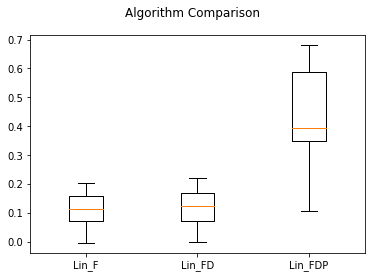

     Model  R2 Score (Min)  R2 Score (Max)  R2 Score (Mean)  R2 Score (Std)
0    Lin_F       -0.005040        0.202668         0.109394        0.066221
1   Lin_FD       -0.002947        0.221689         0.119437        0.071657
2  Lin_FDP        0.104797        0.679855         0.419472        0.196610


In [ ]:
from sklearn import model_selection

names = ['Lin_F','Lin_FD','Lin_FDP']
scoring='r2'
results = []
table = []

for name in names:
  # get model
  model = sklearn.linear_model.LinearRegression()

  # do cross-validation
  kfold = model_selection.KFold(n_splits=10)
  cv_results = model_selection.cross_val_score(model, inputs.get(name), y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  table.append([name,np.min(cv_results),np.max(cv_results),cv_results.mean(),cv_results.std()])


# boxplot of algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig("boxplot_r2_comparison.png")
plt.show()

# table of algorithm comparison
table2 = pd.DataFrame(data=table,columns=['Model','R2 Score (Min)','R2 Score (Max)','R2 Score (Mean)','R2 Score (Std)'])
print(table2)
table2.to_csv("overall_r2_comparison.csv",index=False)

Score: 0.43539068886580734


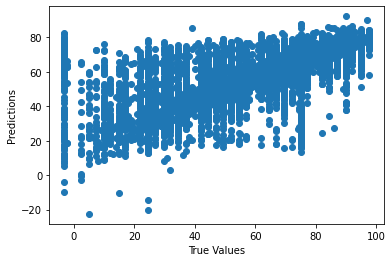

In [ ]:
# Plot actual vs. predictived values

X_train, X_test, y_train, y_test = train_test_split(X_select, y, test_size=0.2)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

# fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print ("Score:", model.score(X_test, y_test))
